In [1]:
import os, sys

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors

sns.set(style="whitegrid")

from sklearn.utils.extmath import row_norms
from sklearn.metrics.pairwise import _euclidean_distances
from tqdm.auto import tqdm

project_dir = os.path.abspath("..")
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

from yace.run_worker import JobInfo

In [2]:
def get_performance_results(working_dir):
    distortions_rand = pd.read_feather(working_dir/"distortions-random-solutions.feather")
    distortions_conv = pd.read_feather(working_dir/"distortions-convex-solutions.feather")
    
    df1 = distortions_rand.agg(
        rand_distortion_mean=("distortion", np.mean),
        rand_distortion_std=("distortion", np.std),
        rand_distortion_min=("distortion", np.min),
        rand_distortion_max=("distortion", np.max),
    )

    df2 = distortions_conv.agg(
        conv_distortion_mean=("distortion", np.mean),
        conv_distortion_std=("distortion", np.std),
        conv_distortion_min=("distortion", np.min),
        conv_distortion_max=("distortion", np.max),
    )

    performance_results = pd.concat([df1, df2]).T.to_dict(orient="records")[0]
    return performance_results

def get_results(file_paths):
    raw_data = []
    for index, job_info_path in enumerate(file_paths):
        job_info = JobInfo.load_json(job_info_path)
        experiment_type = job_info.command_params["experiment-type"]
        working_dir = job_info_path.parent
        if len(list(working_dir.glob("*.*"))) == 0:
            continue
        perf_results = get_performance_results(working_dir=working_dir)
        duration_secs = int((job_info.completed_at - job_info.started_at).total_seconds())
        raw_data.append({
            "k": job_info.experiment_params["k"],
            "epsilon": job_info.experiment_params["epsilon"],
            "algorithm": job_info.experiment_params["algorithm_name"],
            "running_time": duration_secs,
            **perf_results,
        })
    df_data = pd.DataFrame(raw_data)
    return df_data

def get_raw_results(file_paths):
    data_frames = []
    with tqdm(total=len(file_paths)) as pbar:
        for index, job_info_path in enumerate(file_paths):
            job_info = JobInfo.load_json(job_info_path)
            experiment_type = job_info.command_params["experiment-type"]
            working_dir = job_info_path.parent
            duration_secs = int((job_info.completed_at - job_info.started_at).total_seconds())
            if not (working_dir/"distortions-random-solutions.feather").exists():
                continue
            if not (working_dir/"distortions-convex-solutions.feather").exists():
                continue
            df_perf_data = pd.concat([
                pd.read_feather(working_dir/"distortions-random-solutions.feather"),
                pd.read_feather(working_dir/"distortions-convex-solutions.feather")
            ])
            experiment_id = working_dir.name
            if experiment_id.startswith("2022"):
                experiment_id = experiment_id[0:19]
            else:
                experiment_id = "-".join(experiment_id.split("-")[0:2])
            df_perf_data["experiment_id"] = experiment_id
            df_perf_data["experiment_name"] = working_dir.parent.name
            df_perf_data["experiment_type"] = experiment_type
            df_perf_data["running_time_secs"] = duration_secs
            df_perf_data["job_info_path"] = job_info_path
            
            df_perf_data["algorithm"] = job_info.experiment_params["algorithm_name"]
            
            for param, val in job_info.experiment_params.items():
                df_perf_data[f"{param}"] = val
            data_frames.append(df_perf_data)
            pbar.update()
    df_data = pd.concat(data_frames)
    return df_data

def add_combined_mean_std(df: pd.DataFrame, attr: str):
    def combiner(row) -> str:
        mean = row[f"{attr}_mean"]
        std =  row[f"{attr}_std"]
        return f"{mean:0.4f} ({std:0.5f})"
    df[f"{attr}_mean_std"] = df.apply(lambda x: combiner(x), axis=1)


In [3]:
job_info_paths  = []
job_info_paths += list(Path("../data/experiments-skadi/simple/epsilon_0_20/").glob("**/job-info.json"))
job_info_paths += list(Path("../data/experiments-skadi/simple/epsilon_0_10/").glob("**/job-info.json"))
job_info_paths += list(Path("../data/experiments-skadi/simple/epsilon_0_05/").glob("**/job-info.json"))
job_info_paths += list(Path("../data/experiments-skadi/simple/epsilon_0_01/").glob("**/job-info.json"))
print(f"Number of job files: {len(job_info_paths)}")

Number of job files: 3216


In [4]:
df_raw_results = get_raw_results(job_info_paths)
df_raw_results["k_formatted"] = "$k$=" + df_raw_results["k"].astype(str)
print(f"Number of results: {df_raw_results.shape[0]}")

  0%|          | 0/3216 [00:00<?, ?it/s]

Number of results: 321600


In [5]:
# Count number of experiments by data set
df_raw_results.groupby(["experiment_name"])[["experiment_id"]].nunique().rename(columns={"experiment_id": "n_experiments"})

,n_experiments
experiment_name,
epsilon_0_01,9
epsilon_0_20,100


In [6]:
colors = sns.color_palette("colorblind")
# algorithms = np.sort(df_raw_results.algorithm.unique())[::-1]
algorithms = ['sensitivity-sampling', 'uniform-sampling', ]
algorithm_colors = {algo: colors[i] for i, algo in enumerate(algorithms)}

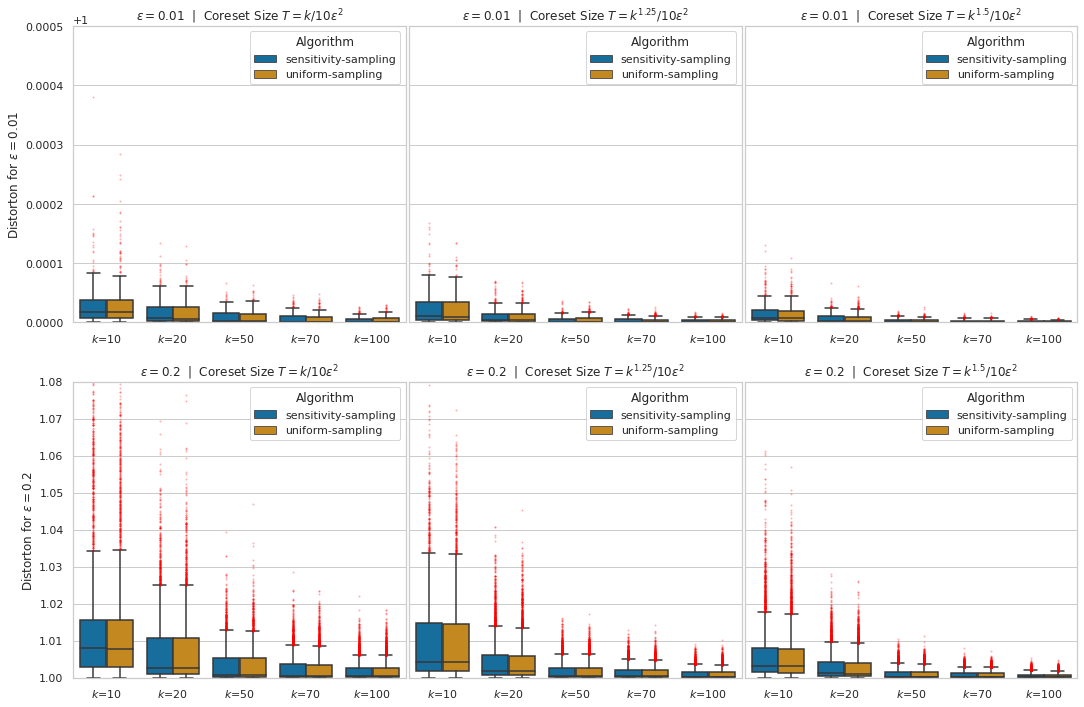

In [11]:
coreset_exps = np.sort(df_raw_results["coreset_exp"].unique())
epsilons = np.sort(df_raw_results["epsilon"].unique())
n_rows = len(epsilons)
n_cols = len(coreset_exps)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharey=False, figsize=(18, n_rows*6))

outlier_points_props = dict(
    markerfacecolor='None',
    markersize=1,
    marker='o',
    markeredgecolor=plt_colors.colorConverter.to_rgba('red', alpha=.3),
)

for i, epsilon in enumerate(epsilons):
    for j, coreset_exp in enumerate(coreset_exps):
        ax = axes[i, j] # axes[i,j]
        f1 = df_raw_results["coreset_exp"] == coreset_exp
        f2 = df_raw_results["epsilon"] == epsilon
        f3 = df_raw_results["algorithm_name"].isin(["uniform-sampling", "sensitivity-sampling"])
        f4 = df_raw_results["solution_type"] == "convex"
        df_filtered = df_raw_results[f1 & f2 & f3].copy()
        df_filtered.sort_values(by=["k", "algorithm_name"], inplace=True)
        sns.boxplot(
            data=df_filtered, x="k_formatted", y="distortion", hue="algorithm_name", palette=algorithm_colors,
            flierprops=outlier_points_props,
            ax=ax
        )
        ax.set_ylim({0.2: [0.9998, 1.08], 0.1: [0.998, 1.4], 0.05: [0.998, 1.2], 0.01: [1.0, 1.0005]}[epsilon])
        coreset_k_val = f"k^{{{coreset_exp}}}" if coreset_exp > 1 else "k"
        ax.set_title(f"$\\epsilon={epsilon}$  |  Coreset Size $T = {coreset_k_val} / 10 \\epsilon^2 $")
        ax.set_ylabel(f"Distorton for $\\epsilon={epsilon}$")
        ax.set_xlabel("")
        if j > 0:
            ax.set_ylabel("")
            ax.set_yticklabels([])
        if i == 0:
            ax.set_xlabel("")
        ax.legend(title="Algorithm")
fig.subplots_adjust(wspace=0.01)
#fig.savefig(f"plots-boxplot-distortions-instance-2.pdf", bbox_inches="tight")